# Live Streaming of Wikipedia Extraction
**The big picture**

[WikiRecentPhase0](imgAna_0.jupyter-py36.ipynb) illustrated accessing continious streams events from a notebook in Python as a way to explore the nature of the data and to understand how to develop it into useful insights. In that exploration data is collected, averages are calculated only as long as the notebook open and specific cells are running. That model makes it challenging to make business use of insights derived from the stream.


In this notebook we will transition the work we did with the data in step 0 to a continuously running Streams job, develop the insights further and show how the Notebook can be used to access the outputs of the job for user visualization and action. This notebook is composed of the number applications each of which refines the 
the data. 



## <a id="Overview  - Continious processing with Streams">OVERVIEW</a>
![graph of application](images/allApplications.png)

## Wiki
**About** 

This notebook composes a number of phases. Each phase is a application that is
indendpendently deployed. The applications communicates via a pub/sub facility. 


- [Collecting Wiki Events](#PHASE1)
- [Aggregating and Filtering)](#PHASE2)
- [Shred Page with Beautiful Soup](#PHASE3)
- [Image Analysis Prep - (Fetch Image)](#PHASE4)
- [Image Analysis ](#PHASE5)



A 'view'enables a developer to observe data that is flowing through the live stream, data presented to the 
view is available for display over the web. Due to the realtime nature of Streams the view may and the 
limitations of web communcations a view will drop observations as resources (CPU, memory, bandwidy) become limited. 
This has not been an issue with this suite of notebooks.

The applications are composed and submitted from the notebook, it runs on a server continiously until it is stopped. This notebook accesses and renders view data in order to see how the Streams is processing the events 
recieved from Wikipedia. 




### Documentation

- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)
- [Topology](https://streamsxtopology.readthedocs.io/en/latest/index.html) Streams Topology documentation
- [Widgets](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html) Notebook Widgets documentation.





## Submit the appplication that has a filter. 

- rough cut look at the data
- plot the 'type' data
- look at the filtered data

##  Collect in buffer / Aggregate
- Last 1000 in local buffer & aggregate
- Render
- Push code to server.

# <a id='SETUP'>Setup</a>

The [README](README.jupyter-py36.ipynb) has details of setting up, at a minimum you will need to setup  credential.py

## <a id='setupImports'>Setup Imports</a>

In [1]:
# Install components
!pip install --user --upgrade streamsx

/bin/sh: pip: command not found


In [2]:
import os
# Need the JAVA to submit, my enviroment is not right, yours may be ok - this is hack. 
try:
    print("JAVA_HOME is set to",os.environ["JAVA_HOME"])
except KeyError as err:
    os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/jdk1.8.0_221.jdk/Contents/Home"
    print("Had to set JAVA_HOME is set to",os.environ["JAVA_HOME"],"\n   --- what is going on here...")

Had to set JAVA_HOME is set to /Library/Java/JavaVirtualMachines/jdk1.8.0_221.jdk/Contents/Home 
   --- what is going on here...


In [3]:
import json
import datetime 
import os
import sys
import time
import threading


from  functools import lru_cache
from statistics import mean
import collections
from collections import deque
from collections import Counter

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, Layout
from IPython.core.debugger import set_trace
from IPython.display import display, clear_output

from bs4 import BeautifulSoup
from sseclient import SSEClient as EventSource
import requests

import streamsx
from streamsx.topology.topology import *
import streamsx.rest as rest
from streamsx.topology import context

#import wiki_streams
import sys

if '../scripts' not in sys.path:
    sys.path.insert(0, '../scripts')
    
import streams_aid as aid
import streams_render as render
import credential
import cvsupport
print("streamsx package version: " + streamsx.topology.context.__version__)



streamsx package version: 1.14.15




#### ICP4D setup

With the cell below selected, click the "Connect to instance" button in the toolbar to insert the credentials for the service.

<a target="blank" href="https://developer.ibm.com/streamsdev/wp-content/uploads/sites/15/2019/02/connect_icp4d.gif">See an example</a>.

In [4]:
%%script false --no-raise-error
from icpd_core import icpd_util
cfg=icpd_util.get_service_instance_details(name='zen-sample-icp1-blitz-env')


#### Cloud setup
To use Streams instance running in the cloud setup a [credential.py](setup_credential.ipynb)



In [5]:
# Use the Cloud Service mapped in credentials.py
SERVICE_NAME='Streaming3Turbine'


### Connect to the server :  ICP4D or Cloud instance -


In [6]:
# The code is setup to run in the Cloud and CP4D. 
# If in the Cloud, you'll see a message.
# If in CP4D, you'll need the service credential, which what the above link explains. 
#    Delete this cell and use the above instructions if you only using CP4D.

try:
    from icpd_core import icpd_util
except ModuleNotFoundError as e:  # get all exceptions
    instance,cfg = aid.get_instance(service_name=SERVICE_NAME)

else:   # runs when no exception occurs
    cfg=icpd_util.get_service_instance_details(name='set your service')

Outside ICP4D


## Connected
When you're up to this point you have established connection to the Streams instance. The cell below shows, if any, the applications that are running. For the applications that are running thier corresponding rendering codes could be executed without going through the process of submitting the application.

In [7]:
aid.list_jobs(instance, cancel=True)

Thier may not be any jobs currently running. 

Continue on to compose an application or [back to Directory](#DIRECTORY) 

<tr style="border-bottom: 1px solid #000;">

# <a id='PHASE1'>Collecting Wiki events (Phase1)</a>

The first appliction recieves Wikipedia updates as events via SSE. An event
has a 'bots' field indicating that it was generated by a robot. Many robots exist Wikipedia to perform
mundane checking tasks: checking, copyright infringment,inappropriate content...
This application will focus on messages generated by humans filtering out those from 'bots'. 
The event has a number of superflous fields that are removed before it is presented to 'view'. 

- get data from wiki usng SSE
- filter data, seperate out the humans and RObots
- setup views : allEvents, allHumans, paredHumans, paredAll
- publish tuples on 'pared_human' topic

## Receive messages updates from Wikipedia
As updates are made to Wikipidia pages the changs are sent over and SSE feed. The get_events() function recieves the events and acting as a [source](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Topology.source) pushes them onto the Streams streams.



In [8]:

def get_events():
    """fetch recent changes from wikievents site using SSE"""
    for change in EventSource('https://stream.wikimedia.org/v2/stream/recentchange'):
        if len(change.data):
            try:
                obj = json.loads(change.data)
            except json.JSONDecodeError as err:
                print("JSON l1 error:", err, "Invalid JSON:", change.data)
            except json.decoder.JSONDecodeError as err:
                print("JSON l2 error:", err, "Invalid JSON:", change.data)
            else:
                yield(obj)


## Filter messages
The [filter](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Stream.filter) is used to break out messages not generated by robots.

## View into the live stream
The [view](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Stream.view) enables access to live stream at runtime. We spread them liberaly throughout the application to observe how the processing is procedeing

## Compose, build and submit the Streams application.¶


The following Code cell composes the Streams application depicted here:

![graph of application](images/phase1.png)

From a single event source (wikiEvents)' we are creating a topology that delivers two streams of derived information.
To make each step in this process accessible to examination we are declaring a view at each stage to look at the raw data and also to attach graphical visualizations. 

A Steams flow is composed by linking operator outputs to inputs.

Two streams are being composed and three views are exposed

1) All source events are sent to 'allEvents' view where they are exposed for viewing.

2) All the source events sent to 'paredAll', where they are pared down to 6 fields and exposed for viewing. 
- the Wikipeida events are output from the 'source' method named 'wikiEvents on 'wiki_events' 
- the input to the 'map' method named 'paredAll'is wiki_events where fields  ('timestamp',type','wiki','bot','user','title') are extracted and output to 'pared_all'. 
- the input to 'view' method is 'named allEvents is 'pared_all' where the are exposed for viewing. 

3) All the source events are sent to 'humansOnly' that drops 'bot' fields of False, they are then are pared down to 5 fields and exposed for viewing.
- the Wikipeida events are output from the 'source' method named 'wikiEvents on 'wiki_events' 
- the input to the 'filter' method named 'humanFilter' only events in whih the 'bot' field set to False are output on all_human. 
- the input to the 'map' method named 'paredHuman' is all_human where fields  ('timestamp',type','wiki','user','title') are extracted and output to 'pared_human'. 
- the input to 'view' method is named 'paredHuman' is 'pared_human' where the are exposed for viewing. 

In [9]:

def WikiPhase1(jobName=None):
    """
    Compose topology 

    """
    topo = Topology(name=jobName)
    topo.add_pip_package('SSEClient===0.0.22')

    ## Receive wiki data 
    wiki_events = topo.source(get_events, name="wikiEvents")
    wiki_events.view(buffer_time=1.0, sample_size=1, name="allEvents", description="All wiki events")
    
    ## drop fields 
    pared_all = wiki_events.map(lambda x : {'timestamp':x['timestamp'],'type':x['type'],'wiki':x['wiki'],'bot':x['bot'],'user':x['user'],'title':x['title']}, name="paredAll")
    pared_all.view(buffer_time=1.0, sample_size=200, name="paredAll", description="All events pared")
    
    ## Filter out bots and non edits
    human_filter = wiki_events.filter(lambda x: x['type']=='edit' and x['bot'] is False, name='humanFilter')
    # pare down the humans set of columns
    pared_human= human_filter.map(lambda x : {'timestamp':x['timestamp'],
                                              'new_len':x['length']['new'],
                                              'old_len':x['length']['old'], 
                                              'delta_len':x['length']['new'] - x['length']['old'],
                                              'wiki':x['wiki'],'user':x['user'],
                                              'title':x['title']}, 
                        name="paredHuman")


    ## drop fields
    pared_human.view(buffer_time=1.0, sample_size=200, name="paredHuman", description="Human events pared")
    pared_human.publish(topic="pared_human", name="pubParedHuman")
    
    return topo

## Submit topology : build/submit (ICP4D or Cloud)

In [10]:

aid.cloudSubmit(instance, SERVICE_NAME, WikiPhase1(jobName="WikiPhase1"), credential=credential)  

Cancelling old job: notebook::WikiPhase1_26


IntProgress(value=0, bar_style='info', description='Initializing', max=10, style=ProgressStyle(description_wid…

Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.n

Next view the data being collected by Streams or [back to Directory](#DIRECTORY) 

## <a id='PHASE1_RENDER'>View data collected by the first Streams application</a>

The running application has number of views to see what what data is moving through the stream. The following 
cell will fetch the views' queue and dipslay it's data when selected. 

|view name | description of data is the view |
|---------|-------------|
|allEvents  | all fields of all events  |
|paredAll | subset of fields for all events |
|paredHumans | subset of fields of all events where field 'bot is **False**|



In [11]:

# Render the views.....

aid.display_views(instance, job_name="WikiPhase1")

RadioButtons(description='Select view to display', options=('allEvents', 'paredAll', 'paredHuman'), value=None…

### Viewing live data:
- constructing the view object : https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html?highlight=view#streamsx.topology.topology.Stream.view
- methods on the view object : https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html?highlight=view#streamsx.topology.topology.View

#### Graph frequency of 'type' events and 'bots'

The following is a example of using widgets to view the live data, accessing the 'paredAll' view data, we're able to
see the counts of edit types to bots/non-bot (human) 


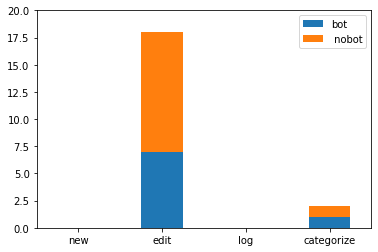

In [12]:

# tally the the bots/types  - SHOW GRAPH
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
%matplotlib inline
from collections import Counter

@aid.catchInterrupt
def tally_bot(view, ele_window=20, count=20):
    """bots vs human updates 
    Args:
        view: Streams view that data will be fetched from
        ele_window : max number of elements in window
        count: number of times to fetch data, < 0 until interrupt 
    
    """

    nam_list = ['new', 'edit', 'log','categorize']
    cntbot = {key:0 for key in nam_list}
    cntnobot = {key:0 for key in nam_list}
    view.start_data_fetch()

    while count != 0:
        count -= 1
        listTuples= view.fetch_tuples(max_tuples=20, timeout=4)
        cntbot = Counter({key:0 for key in nam_list})
        cntnobot = Counter({key:0 for key in nam_list})
        for evt in listTuples:
            if evt['bot']:
                cntbot[evt['type']] += 1
            else:
                cntnobot[evt['type']] += 1
        bot_list = [cntbot[key] for key in nam_list]
        nobot_list = [cntnobot[key] for key in nam_list]
        
        df = pd.DataFrame({'bot': bot_list, ' nobot': nobot_list}, index=nam_list)
        df.plot.bar(rot=0, stacked=True)
        plt.ylim(0.0, ele_window)
        plt.show()
        clear_output(wait=True)

view = aid.get_view(instance, job_name="WikiPhase1", view_name="paredAll")
tally_bot(view=view[0])

### Cancel job when done. 
If you are not going onto next phase, cancel the job.

In [13]:

aid.list_jobs(instance, cancel=True)

## WikiPhase1 application wrapup 

This phase composed and deployed a Streams application that processes live Wikipedia events on a server. After 
filtering the events they're pared down and made avaiable via a view. Using standard notebook widgets
we rendered the view data. 

This application is running on server, once deployed it is not necessary to have notebook open and executing in order to process the data. Future notebooks will collect and average data over windows of events and time. 

The data from this phase is being published on the 'pared_human' topic.

[Back to Directroy](#DIRECTORY)

# <a id='PHASE2'>Aggregating and Filtering - Phase2</a>

- receive tuples on the 'pared_human' topic 
- Normalize the language of submission
- Aggregate the top 10 submitters in the last 10 minutes: time-based windowing
- Aggregate the top articles in the last 200 submissions: event-based windowing
- View live data in notebook, top articles and languages in a "dashboard"
- publish processed tuples on 'lang_augment' topic

![graph of application](images/phase2.png)


## Aggregating tuples
The [aggregation](http://ibmstreams.github.io/streamsx.topology/doc/pythondoc/streamsx.topology.topology.html#streamsx.topology.topology.Window.aggregate) which is performed
accross a list of tuples. The list is defined by a [window](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Window) which can be count or timed based with 
various options. 
in general the function is invoked when the window's
critera are met. 

### Summing fields

In [15]:

class sum_aggregation():
    def __init__(self, sum_map={'new_len':'newSum','old_len':'oldSum','delta_len':'deltaSum' }):
        """
        Summation of column(s) over a window's tuples. 
        Args::
            sum_map :  specfify tuple columns to be summed and the result field. 
            tuples : at run time, list of tuples will flow in. Sum each fields
        """
        self.sum_map = sum_map
    def __call__(self, tuples)->dict: 
        """
        Args:
            tuples : list of tuples constituting a window, over all the tuples sum using the sum_map key/value 
                     to specify the input and result field.
        Returns:
            dictionary of fields summations over tuples
            
        """
        summaries = dict()
        for summary_field,result_field in self.sum_map.items():
            summation = sum([ele[summary_field] for ele in tuples])
            summaries.update({result_field : summation})
        return(summaries)

### Tallying fields

In [16]:

import collections
class tally_fields(object):
    def __init__(self, top_count=3, fields=['user', 'wiki', 'title']):
        """
        Tally fields of a list of tuples.
        Args::
            fields :  fields of tuples that are to be tallied
        """
        self.fields = fields
        self.top_count = top_count
    def __call__(self, tuples)->dict:
        """
        Args::
            tuples : list of tuples tallying to perform. 
        return::
            dict of tallies
        """
        tallies = dict()
        for field in self.fields:
            stage = [tuple[field] for tuple in tuples if tuple[field] is not None]
            tallies[field] = collections.Counter(stage).most_common(self.top_count)
        return tallies

## Mapping tuples

The event's 'wiki' field is the database that events pertains to. The database has a primary language which muliple databases share a common language. We'll use aht wikimap.csv to reconcile the events message using the augment_lang
function using [map](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Stream.map) to drive the processing.

When defining a class be aware that the __init__() is executed locally at compile invocation when the self value is pickeld. Before call is __call__() invoked at runtime the self is depickeled. In the augmentation_lang.__init__() code 
below, csv file is read into dict that maps from 'wiki' to 'language' and saved to *self*. At runtime the *self* with it's wiki/language mapping reconsile the language. 

In [17]:

import csv
class wiki_lang():
    """
    Augment the tuple to include language wiki event.
    
    Mapping is loaded at build time and utilized at runtime.
    """

    def __init__(self, fname="wikimap.csv"):
        self.wiki_map = dict()
        with open(fname, mode='r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                self.wiki_map[row['dbname']] = row

    def __call__(self, tuple):
        """using 'wiki' field to look pages code, langauge and native
        Args:
            tuple: tuple (dict) with a 'wiki' fields
        Returns:'
            input tuple with  'code', 'language, 'native' fields added to the input tuple.
        """
        if tuple['wiki'] in self.wiki_map:
            key = tuple['wiki']
            tuple['code'] = self.wiki_map[key]['code']
            tuple['language'] = self.wiki_map[key]['in_english']
            tuple['native'] = self.wiki_map[key]['name_language']
        else:
            tuple['code'] = tuple['language'] = tuple['native'] = None
        return tuple

## Compose, build and submit the Streams application.
The following Code cell composed the Streams application depicted here:


Three streams and thier views are composed from here. 

1) The aggregate method named 'talliesTop' is preceded by a windowing operation that stages 100 tuples in increments 
of 10. 'talliesTop' tuples are processed by the 'tallies_field()' object that tallies the 'user' and 'titles' fields and returns the results in dict. The dict is forwarded onto the view named 'talliesTop'.

2) The aggregate method named 'sumAggregation' is preceded by windowing that stages 100 with increment of 20. 'sumAggregation' tuples are processed by 'sum_aggregation()' that returns a dict the view named 'sumAggregate' publishes.

3) The map method named 'langAugment' invokes wiki_lang() with each tuple. The wiki_lang() method expands the tuple 
by three fields 'native', 'code', 'language' keying off the 'wiki' field. The resulting tuple is sent onto aggregate
named 'timeLang' is preceded by a windoing operation that stages 2 minutes of tuples in increments of 5. 
'langAugment' tuples are processed by the 'tallies_fields()' object that tallies the 'langugage' fields and returns
the results in a dict. The dict is forwarded onto a view named 'langAugment'

The 'langAugment' tuples are published on the 'lang_augment' topic.


In [18]:

def WikiPhase2(jobName=None):
    """
    UPDATED 
    -- wiki_lang : csv file mapping database name to langauge

    """
    topo = Topology(name=jobName)
    ### make sure we sseclient in Streams environment.

    pared_human = topo.subscribe(topic="pared_human", name="subParedHuman")

    ## Define window(count)& aggregate
    sum_win = pared_human.last(100).trigger(20)
    sum_aggregate = sum_win.aggregate(sum_aggregation(sum_map={'new_len':'newSum','old_len':'oldSum','delta_len':'deltaSum' }), name="sumAggregate")
    sum_aggregate.view(buffer_time=1.0, sample_size=200, name="aggEdits", description="Aggregations of human edits")

    ## Define window(count) & tally edits
    tally_win = pared_human.last(100).trigger(10)
    tally_top = tally_win.aggregate(tally_fields(fields=['user', 'title'], top_count=10), name="talliesTop")
    tally_top.view(buffer_time=1.0, sample_size=200, name="talliesCount", description="Top count tallies: user,titles")

    ## augment filterd/pared edits with language
    if cfg is None:        
        lang_augment = pared_human.map(wiki_lang(fname='../datasets/wikimap.csv'), name="langAugment")
    else:
        lang_augment = pared_human.map(wiki_lang(fname=os.environ['DSX_PROJECT_DIR']+'/datasets/wikimap.csv'), name="langAugment")
    lang_augment.view(buffer_time=1.0, sample_size=200, name="langAugment", description="Language derived from wiki")

    ## Define window(time) & tally language
    time_lang_win = lang_augment.last(datetime.timedelta(minutes=2)).trigger(5)
    time_lang = time_lang_win.aggregate(tally_fields(fields=['language'], top_count=10), name="timeLang")
    time_lang.view(buffer_time=1.0, sample_size=200, name="talliesTime", description="Top timed tallies: language")
   
    ## publish lang_augment
    lang_augment.publish(topic="lang_augment", name="pubLangAugment")
    return topo

In [19]:
aid.cloudSubmit(instance, SERVICE_NAME, WikiPhase2(jobName="WikiPhase2"), credential) 


Cancelling old job: notebook::WikiPhase2_27


IntProgress(value=0, bar_style='info', description='Initializing', max=10, style=ProgressStyle(description_wid…

Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.n

[Back to Directroy](#DIRECTORY)

## <a id='PHASE2_RENDER'>Phase2 Render- WikiPhase2</a>
The Streams application is sending out 5 views which you can seen using the wiget above. The following show the data in more favorable light. 

### Tallied languages

We extreact the languge data and tallied it in Streams. This is showing the submitted events pertaining to article written in various languages in the last 2 minutes. 


[+]90.94% of the events are in English, English is  dropped from the piechart.


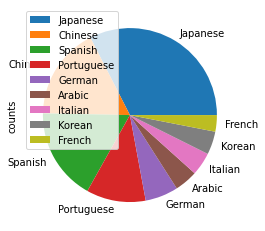

In [20]:
# TODO Cart  - SHOW PIE

@aid.catchInterrupt
def tally_pie(view=None, tally_field='language', count=10):
    """Pie chart of language that edits by humans being done in. 
    Args:
        view: Streams view that data will be fetched from
        tally_field: fields within view to get data.
        count: number of times to fetch data, < 0 until interrupt 
    
    """
    while (count != 0):
        count -= 1
        tuples = view.fetch_tuples(max_tuples=10, timeout=10 )
        if len(tuples) is 0:
            print("No new tuples @{}".format(count))
            time.sleep(3)
            next
        language= [lst[0] for lst in tuples[-1][tally_field]]
        counts = [lst[-1] for lst in tuples[-1][tally_field]]
        percent = counts[0]/sum(counts) * 100
        print("[{2}]{0:4.2f}% of the events are in {1}, {1} is  dropped from the piechart.".format(percent,language[0],"+*"[count%2]))
        df = pd.DataFrame({'counts': counts[1:]}, index=language[1:])
        df.plot.pie(y='counts')    
        plt.show()
        clear_output(wait=True)
        
view = instance.get_views(name="talliesTime")[0]
view.start_data_fetch()
tally_pie(view, tally_field='language')

###  Tally users
Show the users who have submitted the most events in the last 200 events. 

In [21]:
%%script false --no-raise-error
## problem with upgrade : pd.DataFrame.from_items(tbl) - fix not work as described
@aid.catchInterrupt
def tally_table(view=None, tally_field="title", count=10):
    """Display a title data in a table
    Args:
        view: Streams view that data will be fetched from
        tally_field: fields within view to get data.
        count: number of times to fetch data, < 0 until interrupt 
 
    """
    while (count != 0):
        count = count - 1
        tallies = view.fetch_tuples(max_tuples=10, timeout=6)
        if tallies is not None and len(tallies) != 0:
            title_tallies = tallies[0][tally_field]
            title = [ele[0] for ele in title_tallies]
            cnt = [ele[1] for ele in title_tallies]
            tbl = [(tally_field, title),('count', cnt)]
            #df = pd.DataFrame.from_items(tbl)
            df = Dataframe.from_dict(dict(tbl))
            
            display(df)
        else:
            display("Fetch Fail count down value ... {}".format(count))
            time.sleep(3)
        clear_output(wait=True)
view = instance.get_views(name="talliesCount")[0]
view.start_data_fetch()
tally_table(view, tally_field="user", count=5)

### Tally titles

Show the most updated titles within the last 200 events.


In [22]:
%%script false --no-raise-error

view = instance.get_views(name="talliesCount")[0]
view.start_data_fetch()
tally_table(view, tally_field="title", count=5)

### Wrapup WikiPhase2


Continue onto the next phase or back up to directory....



## <a id='PHASE3'>Shred Page with Beautiful Soup - Phase3</a>

Check if the event is associated with an image, if it is extract the image URL. 

- subscribe to the 'lang_augment' topic tuples on the 
- analyze wiki updates to find image links
- shred pages using a Python package (beautifulsoup)
- view live data in notebook, render images submitted to Wikipedia
- publish on the 'soup_active' topic
![graph of application](images/phase3.png)



<a id='composeBuildSubmit'></a>
### Compose, build and submit the Streams application.


This section subscribes to the previous, in this we be using the 'lang_augmement' subscription. 

The events output by the map named 'langAugment' are limited to those with of type 'edit' and bot is 'False'. The fields are: code, delta_len, language, native, new_len, old_len, timestamp, title, user and wiki. This phase uses the 'title' field to build a url of a webpage, the webpage is feched and processed looking for a image URL.

The map method named 'imageSoup' invokes soup_image_extract() where it uses the 'title' field attempting to locate an image. If no image is found, None is returned and nothing flows out of the operator. If an image is found then the output includes a 'img_desc' field. A filter is applied to the 'img_desc' for content, if it does have content the tuple procedes to the view 'soupActive' where it can be viewed.


In [23]:

# %load -s tally_fields ../scripts/wiki_streams.py
class tally_fields(object):
    def __init__(self, top_count=3, fields=['user', 'wiki', 'title']):
        """
        Tally fields of a list of tuples.

        Args::
            fields :  fields of tuples that are to be tallied

        Note::
           Refer to the %load command's file for further details.

        """
        import collections
        self.fields = fields
        self.top_count = top_count
    def __call__(self, tuples)->dict:
        """
        Args::
            tuples : list of tuples tallying to perform.
        return::
            dict of tallies
        """
        tallies = dict()
        for field in self.fields:
            stage = [tuple[field] for tuple in tuples if tuple[field] is not None]
            tallies[field] = collections.Counter(stage).most_common(self.top_count)
        return tallies


In [24]:

from streams_operations import soup_image_extract
def WikiPhase3(jobName=None, wiki_lang_fname=None):
    """
    Compose topology. 
    -- wiki_lang : csv file mapping database name to langauge

    """
    topo = Topology(name=jobName)
    ### make sure we sseclient in Streams environment.
    topo.add_pip_package('SSEClient===0.0.22')
    topo.add_pip_package('bs4')
    topo.add_pip_package('ipynb')

    lang_augment =topo.subscribe(topic="lang_augment", name="subLangAugment")
    
    ## Define window(time) & tally language
    time_lang_win = lang_augment.last(datetime.timedelta(minutes=2)).trigger(5)
    time_lang = time_lang_win.aggregate(tally_fields(fields=['language'], top_count=10), name="timeLang")
    time_lang.view(buffer_time=1.0, sample_size=200, name="talliesTime", description="Top timed tallies: language")

    ## attempt to extract image using beautifulsoup add img_desc[{}] field
    soup_image = lang_augment.map(soup_image_extract(field_name="title", url_base="https://www.wikidata.org/wiki/"),name="imgSoup")
    soup_active = soup_image.filter(lambda x: x['img_desc'] is not None and len(x['img_desc']) > 0, name="soupActive")
    soup_active.view(buffer_time=1.0, sample_size=200, name="soupActive", description="Image extracted via Bsoup")
    soup_active.publish(topic="soup_active", name="pubSoupActive")

    return topo

aid.cloudSubmit(instance, SERVICE_NAME, WikiPhase3(jobName="WikiPhase3"), credential) 


Cancelling old job: notebook::WikiPhase3_28


IntProgress(value=0, bar_style='info', description='Initializing', max=10, style=ProgressStyle(description_wid…

Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.n

Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"



The running application has number of views to see what what data is moving through the stream. The following 
cell will fetch the views' queue and display it's data when selected. 

|view name | description of data is the view | bot |
|---------|-------------|------|
|talliesTimes | 2 minute windowed | False |
|soupActive | extracted images links| False | 


You want to stop the the fetching the view data when done.

In [26]:
aid.display_views(instance, job_name="WikiPhase1")
aid.display_views(instance, job_name="WikiPhase2")
aid.display_views(instance, job_name="WikiPhase3")

RadioButtons(description='Select view to display', options=('allEvents', 'paredAll', 'paredHuman'), value=None…

RadioButtons(description='Select view to display', options=('aggEdits', 'langAugment', 'talliesCount', 'tallie…

RadioButtons(description='Select view to display', options=('soupActive', 'talliesTime'), value=None)

[Back to Directroy](#DIRECTORY)

## <a id='PHASE3_RENDER'>Render Shredding</a>

## Acces Views / Render Views UI

## Render image submitted to wiki feed 
Build dashboard to display images are being submitted to Wikipedia. 

It's not uncommon to see the  same image multiple times. An image (any content) may need to be vetted for 
quailty, copyright, pornograpy etc... Each vet stage generating another event on the Stream

A variety of images are submitted, unfortunaly not all images are rendered in all browsers. I found that the Safari 
browser and render .tif files. 


In [27]:
# Notebook support

def render_image(image_url=None, output_region=None):
    """Write the image into a output region.
    
    Args::
        url: image
        output_region: output region
        
    .. note:: The creation of the output 'stage', if this is not done the image is rendered in the page and
        the output region. 
        
    """
    
    try:
        response = requests.get(image_url)
        stage = widgets.Output(layout={'border': '1px solid green'})
    except:
        print("Error on request : ", image_url)
    else:
        if response.status_code == 200:
            with output_region:
                stage.append_display_data(widgets.Image(
                    value=response.content,
                    #format='jpg',
                    width=300,
                    height=400,
                ))
            output_region.clear_output(wait=True) 

ana_stage = list()
def display_image(tup, image_region=None, title_region=None, url_region=None):
    if tup['img_desc'] is not None and len(tup['img_desc']) > 0:
        display_desc = tup['img_desc'][0]
        ana_stage.append(display_desc)
        title_region.value = "Img Title:{}".format(display_desc['title'] )
        url_region.value = "{}".format(display_desc['img'])
        render_image(image_url=display_desc['img'], output_region=image_region)

In [28]:
## Setup the Dashboard - display images sent to Wikipedia 
##                         Next cell populates the 'Dashboard'.....
status_widget = widgets.Label(value="Status", layout={'border': '1px solid green','width':'30%'})
url_widget = widgets.Label(value="Img URL", layout={'border': '1px solid green','width':'100%'})
image_widget = widgets.Output(layout={'border': '1px solid red','width':'30%','height':'270pt'})
title_widget = widgets.Label(value="Title", layout={'border': '1px solid green','width':'30%'})

dashboard = widgets.VBox([status_widget, image_widget, title_widget, url_widget])
display(dashboard)

In [29]:
# Notebook support - SHOW IMAGES
# setup 
_view = instance.get_views(name="soupActive")[0]
_view.start_data_fetch()


@aid.catchInterrupt
def server_soup(count=25):
    """Fetch and display images from view.
    Args::
        count: number of iterations to fetch images, count<0
        is infinite
    """
    while count != 0:
        count -= 1
        view_tuples = _view.fetch_tuples(max_tuples=100, timeout=2)
        for soup_tuple in view_tuples:
            status_widget.value = soup_tuple['title']
            display_image(soup_tuple, image_region=image_widget, title_region=title_widget, url_region=url_widget)

server_soup(count=5)
### List the active Streams applications
aid.list_jobs(instance, cancel=True)

### Section wrap up.¶
In this section composed and deployed a Streams application that processes live Wikipedia events on a server. It 
extended the previous application to extract images assocated with the event. In the case that the event
does have an associated image, it pushed out to a view where it was rendered. 


In the next section we will continue the build out, using the extraced image we'll  apply AI image processing to extract out faces an score them. 

[Back to Directory](#DIRECTORY)

# <a id='PHASE4'>Impage Analysis Prep (phase4)</a>

- subscribe to the 'soup_active' topic 
- fetch image using url 
- encode image 
- publish to the 'image_active' topic.

![graph of application](images/webImageFetch.png)


We've extracted image url from the Wikipedia update. The next phase is to 
analyze the image for objects and faces. In order to analyze the image it needs to be fetched
using the URL.  


In [30]:
import cvsupport

def ImageWebFetch():
    """Fetch image using the url, place encode image in Stream.
    The encoded image is ascii so it can pass through json.
    
    - fetch the image into 'image_string'
    
    """
    topo = Topology("ImageWebFetch")
    topo.add_pip_package('opencv-contrib-python')
    soup_active = topo.subscribe(topic="soup_active", name="subSoupActive")
    active_image = soup_active.map(cvsupport.ImageFetch(), name="image_fetch")
    active_image.view(name="image_fetch", description="encoded binary image")
    active_image.publish(topic="image_active", name="pubImageActive")
    return topo

aid.cloudSubmit(instance, SERVICE_NAME, ImageWebFetch(), credential) 


Cancelling old job: notebook::ImageWebFetch_29


IntProgress(value=0, bar_style='info', description='Initializing', max=10, style=ProgressStyle(description_wid…

Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.n

# <a id='PHASE5'>Image Analysis</a>


At this point the images are being published on 'image_active' topic. The processing of this images will be done in the [VideoImageAnalysis](videoImageAnalysis.jupyter-py36.ipynb). The application composed in the VideoImageAnalysis will subscribe to the 'image_active'. 

In addition to the previous application publishing to 'image_active' Kafka (EventStreams) based application 
accepts messages from Kafka and publishe to 'image_active'. The [CroppedCamSender](croppedCamSender.jupyter-py36.ipynb) shreds video files and transmits them via Kafka to be processed by 'VideoImageAnalysis' code. 




